In [1]:
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
aws_psql_conn = psycopg2.connect(
    database=os.getenv("AWS_PSQL_DB"),
    user=os.getenv("AWS_PSQL_USER"),
    password=os.getenv("AWS_PSQL_PASSWORD"),
    host=os.getenv("AWS_PSQL_HOST"),
    port=os.getenv("AWS_PSQL_PORT"),
)

cursor = aws_psql_conn.cursor()

In [3]:
sql = f"select * from games"

cursor.execute(sql)

rows = cursor.fetchall()

column_names = [desc[0] for desc in cursor.description]

In [4]:
df = pd.DataFrame(rows, columns=column_names)

print(df.head)

<bound method NDFrame.head of       game_id  home_team_id      home_team_name  away_team_id  \
0      718698           158   Milwaukee Brewers           121   
1      718781           147    New York Yankees           137   
2      718782           111      Boston Red Sox           110   
3      718777           112        Chicago Cubs           158   
4      718776           139      Tampa Bay Rays           116   
...       ...           ...                 ...           ...   
1810   716694           147    New York Yankees           116   
1811   716689           144      Atlanta Braves           138   
1812   716688           118  Kansas City Royals           145   
1813   716687           140       Texas Rangers           117   
1814   716690           108  Los Angeles Angels           110   

            away_team_name      home_pitcher  home_pitcher_id  \
0            New York Mets     Corbin Burnes         669203.0   
1     San Francisco Giants       Gerrit Cole         543037

In [5]:
columns_to_remove = [
    "home_team_name",
    "away_team_name",
    "home_pitcher",
    "home_pitcher_id",
    "away_pitcher",
    "away_pitcher_id",
]

df = df.drop(columns=columns_to_remove)

print(df.head)

<bound method NDFrame.head of       game_id  home_team_id  away_team_id  home_pitcher_era  \
0      718698           158           121              7.20   
1      718781           147           137               NaN   
2      718782           111           110               NaN   
3      718777           112           158               NaN   
4      718776           139           116               NaN   
...       ...           ...           ...               ...   
1810   716694           147           116              4.56   
1811   716689           144           138              3.56   
1812   716688           118           145              6.29   
1813   716687           140           117              3.55   
1814   716690           108           110              4.19   

      home_pitcher_win_percentage  home_pitcher_wins  home_pitcher_losses  \
0                           0.000                0.0                  1.0   
1                             NaN                NaN       

In [6]:
df = df.dropna()

print(df.head)

<bound method NDFrame.head of       game_id  home_team_id  away_team_id  home_pitcher_era  \
0      718698           158           121              7.20   
72     718703           119           115              3.00   
73     718704           120           139              6.00   
74     718701           146           142              0.00   
77     717821           116           109              5.23   
...       ...           ...           ...               ...   
1795   716704           118           145              5.15   
1796   716706           108           110              5.01   
1797   716702           109           115              6.21   
1798   716707           133           141              5.92   
1799   716703           135           143              2.67   

      home_pitcher_win_percentage  home_pitcher_wins  home_pitcher_losses  \
0                           0.000                0.0                  1.0   
72                          1.000                1.0       

In [7]:
df.columns

Index(['game_id', 'home_team_id', 'away_team_id', 'home_pitcher_era',
       'home_pitcher_win_percentage', 'home_pitcher_wins',
       'home_pitcher_losses', 'home_pitcher_innings_pitched',
       'away_pitcher_era', 'away_pitcher_win_percentage', 'away_pitcher_wins',
       'away_pitcher_losses', 'away_pitcher_innings_pitched', 'winning_team',
       'home_pitcher_k_nine', 'home_pitcher_bb_nine', 'home_pitcher_k_bb_diff',
       'home_pitcher_whip', 'home_pitcher_babip', 'away_pitcher_k_nine',
       'away_pitcher_bb_nine', 'away_pitcher_k_bb_diff', 'away_pitcher_whip',
       'away_pitcher_babip', 'predicted_winner'],
      dtype='object')

In [8]:
X = []
Y = []

for index, row in df.iterrows():
    pitcher_innings_pitched_comp = row['away_pitcher_innings_pitched'] - row['home_pitcher_innings_pitched']
    pitcher_k_nine_comp = row['away_pitcher_k_nine'] - row['home_pitcher_k_nine']
    pitcher_bb_nine_comp = row['away_pitcher_bb_nine'] - row['home_pitcher_bb_nine']
    pitcher_k_bb_diff_comp = row['away_pitcher_k_bb_diff'] - row['home_pitcher_k_bb_diff']
    pitcher_whip_comp = row['away_pitcher_whip'] - row['home_pitcher_whip']
    pitcher_babip_comp = row['away_pitcher_babip'] - row['home_pitcher_babip']

    comparison = [pitcher_innings_pitched_comp, pitcher_k_nine_comp, pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, pitcher_whip_comp, pitcher_babip_comp]

    X.append(comparison)
    Y.append(1 if row['winning_team'] == row['home_team_id'] else 0)


In [9]:
# Convert the lists to NumPy arrays for compatibility with scikit-learn
X = pd.np.array(X)
Y = pd.np.array(Y)
X = X.reshape(X.shape[0], -1)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (921, 6)
X_test shape: (231, 6)
Y_train shape: (921,)
Y_test shape: (231,)


In [11]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [12]:
# Make predictions on the training set (you can use a separate test set for predictions)
pred = model.predict(X_test)

zeroes = 0
ones = 0

for item in pred:
    if item == 0:
        zeroes += 1
    elif item == 1:
        ones += 1

print(zeroes, ones)


65 166


In [13]:
# Evaluate the model's performance (e.g., accuracy, precision, recall)
accuracy = model.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.4805194805194805


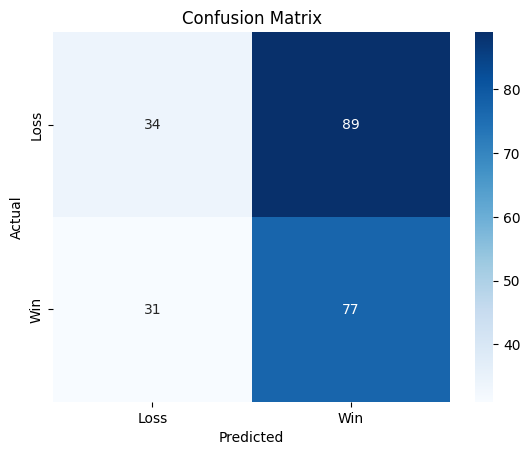

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(Y_test, pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Loss', 'Win'])
plt.plot(1, 1)
plt.yticks([0.5, 1.5], ['Loss', 'Win'])

# Display the plot
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Generate a classification report
classification_rep = classification_report(Y_test, pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.52      0.28      0.36       123
           1       0.46      0.71      0.56       108

    accuracy                           0.48       231
   macro avg       0.49      0.49      0.46       231
weighted avg       0.50      0.48      0.46       231

